# Web Scrapping Project on Grand Prix Results in Formula 1 since 1950.

Tools : 
 * BeautifulSoup4
 * Pandas

Goal : 
Gather the data from 1950 to the current date on Formula 1 Grand Prix results from the official website

# I - Scrapping data from the official website

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import seaborn as sns

In [2]:
# When changing the year, call for the first race of that new year
def getFirstRaceOfNextYear(url):
    # Fetching the base page of a new year in order to retrieve its first race.
    URL = f'{base_url}{url}'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Retrieving the first race data href in the 5th div of the main navigation form.
    # hint : The second line ( find_all('li')[1] ) is the first race because the very first ( find_all('li')[0] ) is the base page itself ( "all" )
    return soup.find('div', {'class': 'resultsarchive-filter-container'}).findChildren("div", recusive=False)[4].find('ul').find_all('li')[1].findChildren('a')[0].get('href')

In [3]:
# When a Grand Prix result is totally fetched, getting the URL of the next Grand Prix
def getNextParams(soupItem, currentSuffix, year):
    # Getting the list of the current year races.
    li = soupItem.findChildren("div", recusive=False)[4] \
                 .find('ul') \
                 .find_all('li')

    # We store the first href of that list
    last_href = li[0].findChildren('a')[0].get('href')

    for line in li:
        href = line.findChildren('a')[0].get('href')

        # If the nth-1 href is equal to the current suffix, returning the nth href
        if last_href == currentSuffix:
            return href, year

        last_href = href
    
    # Being here means we are at the last race of one year. We hence have to look to the first race of the next year.
    year += 1
    li = soupItem.findChildren("div", recusive=False)[0].find('ul').find_all('li')

    if year - 1950 < len(li)+1:
        return getFirstRaceOfNextYear(
                  li[-(1+(year-1950))].findChildren('a')[0].get('href')
               ), year  
    else:
        return None, None

In [4]:
year = 1950
base_url = "https://www.formula1.com"
first_url_suffix = "/en/results.html/1950/races/94/great-britain/race-result.html"
nextSuffix = first_url_suffix
dataframe_data = []
end = False

In [5]:
try:
  while not end:
            
    # Fetching data from formula1.com on a specific Grand Prix on a specific year.
    URL = f'{base_url}{nextSuffix}'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Fetching and cleaning the Grand Prix name from the header 1 of the page
    grand_prix = re.sub(r'\s+', ' ', soup.find('h1', {'class': 'ResultsArchiveTitle'}).find(text=True).strip() )

    table = soup.find('table', {'class': 'resultsarchive-table'})
    rows = table.tbody.find_all('tr')

    # Appending every relevant data in rows to the dataframe_data list
    for row in rows:
      row_data = row.find_all('td')
      driver = row_data[3].findChildren("span", recursive=False)

      dataframe_data.append(
      {
        'Position': row_data[1].find(text=True),
        "Driver": f"{driver[0].find(text=True)} {driver[1].find(text=True)}", 
        "Car": row_data[4].find(text=True), 
        "Points": row_data[7].find(text=True), 
        "Grand Prix": grand_prix, 
        'Duration': row_data[6].find(text=True),
        "Year": year
      })

      # Getting the next page URL to fetch from the main navigation form
    nextSuffix, year = getNextParams(soup.find('div', {'class': 'resultsarchive-filter-container'}), nextSuffix, year)
    
    if not nextSuffix:
      end = True
except Exception as e:
  pass

In [6]:
# Storing the data into a panda dataframe
df = pd.DataFrame (dataframe_data, columns = ['Position', 'Driver','Car', 'Points', 'Grand Prix', 'Duration', 'Year'])

In [7]:
df.shape

(23015, 7)

In [8]:
df.head()

,Position,Driver,Car,Points,Grand Prix,Duration,Year
0,1,Nino Farina,Alfa Romeo,9,1950 British Grand Prix - RACE RESULT,2:13:23.600,1950
1,2,Luigi Fagioli,Alfa Romeo,6,1950 British Grand Prix - RACE RESULT,+2.600,1950
2,3,Reg Parnell,Alfa Romeo,4,1950 British Grand Prix - RACE RESULT,+52.000,1950
3,4,Yves Giraud Cabantous,Talbot-Lago,3,1950 British Grand Prix - RACE RESULT,+2,1950
4,5,Louis Rosier,Talbot-Lago,2,1950 British Grand Prix - RACE RESULT,+2,1950


# II - Exploiting data

In [9]:
years = [x for x in range(1950, 2021)]

In [10]:
ferrari_wins = [0 for x in range(1950, 2021)]
renault_wins = [0 for x in range(1950, 2021)]
williams_wins = [0 for x in range(1950, 2021)]
grand_prix_total = [0 for x in range(1950, 2021)]

for index, row in df.loc[df['Position'] == '1'].iterrows():
  grand_prix_total[int(row['Year'])-1950] += 1
  if row['Car'] == 'Ferrari':
    ferrari_wins[int(row['Year'])-1950] += 1
  elif row['Car'] == 'Renault':
    renault_wins[int(row['Year'])-1950] += 1
  elif 'Williams' in row['Car']:
    williams_wins[int(row['Year'])-1950] += 1

ferrari_win_percent = [(i / j) * 100 for i, j in zip(ferrari_wins, grand_prix_total)]
renault_win_percent = [(i / j) * 100 for i, j in zip(renault_wins, grand_prix_total)] 
williams_win_percent = [(i / j) * 100 for i, j in zip(williams_wins, grand_prix_total)] 

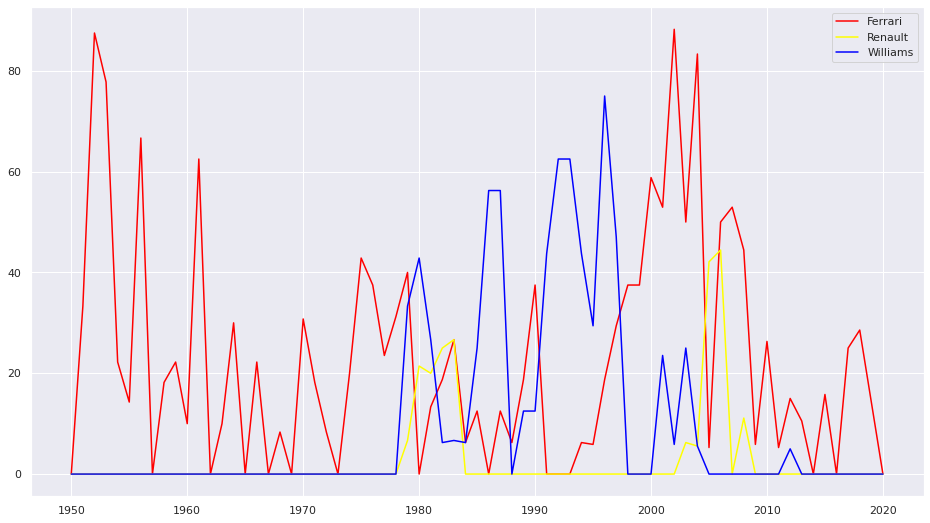

In [11]:
sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(x=years, y=ferrari_win_percent, color='red', label="Ferrari")
sns.lineplot(x=years, y=renault_win_percent, color='yellow', label="Renault")
sns.lineplot(x=years, y=williams_win_percent, color='blue', label="Williams")